# Saturation Reserved

run script color_gi_run22i.py in desc-stack-weekly kernel first

In [1]:
# This script is compatible with desc-stack-weekly kernel.
%matplotlib inline
import sqlite3
import os
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import seaborn as sns
from lsst.daf.persistence import Butler

from lsst.geom import Point2D, Point2I
import lsst.geom as geom


def get_skycoords_from_src(src):
    ra = src.coord_ra.map(np.rad2deg)
    dec = src.coord_dec.map(np.rad2deg)
    coord = SkyCoord(ra, dec, frame="icrs", unit="deg")
    return coord

def remove_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

def keep_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) > 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

def get_truth_type(val):
    if int(val) == 1:
        return 'galaxy'
    elif int(val) == 2:
        return 'star'
    elif int(val) == 3:
        return SN
    else:
        return 'uknown'

def radec_in_image(ra, dec, bbox, wcs):
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    xy = wcs.skyToPixel(radec)
    # point2D to point2I
    point2i = Point2I(round(xy.x), round(xy.y))
    return bbox.contains(point2i)


def cal_fraction(arr):
    return arr.astype(int).sum() / len(arr)

def cal_count(arr):
    return len(arr)

def get_heatmap(df, x_name, y_name, x_bins, y_bins, agg_condition, rename_col=None):
    # group df by x_name and y_name, calculate heats using agg_condition in each group
    df_copy = df.copy()
    x_bin_id = pd.cut(df_copy[x_name], bins=x_bins, labels=False, include_lowest=True)
    df_copy['x_bin_id'] = x_bin_id
    y_bin_id = pd.cut(df_copy[y_name], bins=y_bins, labels=False, include_lowest=True)
    df_copy['y_bin_id'] = y_bin_id
    # reset_index reset the multi-index back to columns
    heatmap = df_copy.groupby(['x_bin_id', 'y_bin_id']).agg(agg_condition).reset_index()
    if rename_col is not None:
        heatmap = heatmap.rename(columns=rename_col)
    return heatmap

def plot_heatmap(heatmap, xticklabels, yticklabels, heat, annotation, xlabel, ylabel, title, figsize):
    # plot the heatmap by x_name and y_name
    # xticklabels and yticklabels are bin edge labels
    heatmap_data = heatmap.pivot(index='y_bin_id', columns='x_bin_id', values=heat)
    heatmap_annot = heatmap.pivot(index='y_bin_id', columns='x_bin_id', values=annotation)
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=heatmap_annot.to_numpy().astype(int), cmap='coolwarm', fmt='d', linewidths=.5)
    print(plt.xticks()[0], plt.yticks()[0])
    plt.xticks(ticks=np.arange(len(xticklabels)), labels=np.round(xticklabels, 2))
    plt.yticks(ticks=np.arange(len(yticklabels)), labels=np.round(yticklabels, 2))
    
    plt.gca().invert_yaxis()
    plt.xticks(rotation=0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
from astropy.coordinates import match_coordinates_sky

def two_direction_skymatch(coord, cat_coord, radius=0.4 * u.arcsec):
    # coord is in degree unit
    idx, sep2d, _ = match_coordinates_sky(coord, cat_coord)
    idx_, _, _ = match_coordinates_sky(cat_coord, coord)
    sep2d = sep2d.to(u.arcsec)
    dist_status = sep2d < radius
    matched_status = idx_[idx] == np.arange(len(idx))
    matched_status = np.logical_and(dist_status, matched_status)
    return matched_status, idx

def merge_two_dfs(df_l, df_r, matched_status, idx, suffixes):
    # set "drop" to true to remove original index
    matched_id = idx[matched_status]
    left = df_l.copy()
    right = df_r.copy()
    left = left[matched_status].copy().reset_index(drop=True)
    right = right.iloc[matched_id].copy().reset_index(drop=True)
    merged = left.merge(right, left_index=True, right_index=True, suffixes=suffixes) 
    return merged

In [2]:
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)

/tmp/ipykernel_759459/2126419260.py:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  calexp_butler = Butler(calexp_repo)
/tmp/ipykernel_759459/2126419260.py:2: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  calexp_butler = Butler(calexp_repo)


lsst.CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3


In [3]:
# read image files
data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
image_table = pd.read_csv(os.path.join(data_dir, 'table/gal_4639/image_info_20_21_m20.csv'))
# get artifact
db = f'/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
mag = 20
artifacts = pd.read_sql_query(f"SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = {mag}", conn)
# backgropund sources
truth_dir = './background_sources_run22i/'

In [4]:
# beginX and beginY are zeros.
"""
for idx, row in image_table.iterrows():

    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    calexp_bbox = calexp_butler.get('calexp_bbox', dataId=calexp_id)
    print(f'bx: {calexp_bbox.beginX}, by: {calexp_bbox.beginY}, 'f'cx: {calexp_bbox.centerX}, cy: {calexp_bbox.centerY}')
""";

In [5]:
# only part of the sources from the truth table can be matched
"""
color_df = pd.DataFrame()
for idx, row in image_table.iterrows():

    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    # get dia src table
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    src = calexp_butler.get('src', calexp_id)
    src_pd = src.asAstropy().to_pandas()
    src_coord = get_skycoords_from_src(src_pd)
    
    # get coords of background sources from truth table
    truth = pd.read_csv(os.path.join(truth_dir, f'{visit}_{det}_run22i.csv'))
    truth_coord = SkyCoord(truth.ra, truth.dec, frame="icrs", unit="deg")
    
    # match src to truth
    matched_status, matched_id = two_direction_skymatch(
        truth_coord, src_coord, radius=2 * u.arcsec)
    print(matched_status.sum() / len(truth_coord))
""";

In [11]:
truth_dir = './background_sources_run22i/'
joint = pd.DataFrame()
joint_dipole = pd.DataFrame()

for idx, row in image_table.iterrows():
    ###############################################
    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    # get dia src table
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    src = calexp_butler.get('src', calexp_id)
    src_df = src.asAstropy().to_pandas()
    photocalib = calexp_butler.get('calexp_photoCalib', dataId=calexp_id)
    wcs = calexp_butler.get('calexp_wcs', dataId=calexp_id)
    bbox =  calexp_butler.get('calexp_bbox', dataId=calexp_id)
    cx, cy = bbox.centerX, bbox.centerY
    
    src_df['mag_i_from_PsfFlux'] = src_df.base_PsfFlux_instFlux.map(photocalib.instFluxToMagnitude)
    # magnitude cut
    src_df = src_df[src_df['mag_i_from_PsfFlux']<23].copy().reset_index(drop=True)
    distance = np.sqrt((src_df.base_NaiveCentroid_x - cx)**2 + (src_df.base_NaiveCentroid_y - cy)**2)
    src_df['distance'] = distance
    src_coord = get_skycoords_from_src(src_df)
    #################################################
    # match to truth
    #################################################
    # get truth table
    truth = pd.read_csv(os.path.join(truth_dir, f'{visit}_{det}_run22i.csv'))
    # in_image = truth.apply(lambda row: radec_in_image(row['ra'], row['dec'], bbox, wcs), axis=1)
    # truth = truth[in_image].copy().reset_index(drop=True)
    mag_gi = truth.mag_g - truth.mag_i
    truth_name = truth.truth_type.map(get_truth_type).copy()
    truth.insert(len(truth.columns), 'mag_gi', mag_gi)
    truth.insert(len(truth.columns), 'truth_name', truth_name)
    # truth coord
    truth_coord = SkyCoord(truth.ra, truth.dec, frame="icrs", unit="deg")
    #####################################################
    # match src to truth
    matched_status_truth, id_truth = two_direction_skymatch(src_coord, truth_coord, radius=1 * u.arcsec)
    sources = merge_two_dfs(src_df, truth, matched_status_truth, id_truth, suffixes=[None, '_truth'])
    sources_coord = get_skycoords_from_src(sources)
    ###################################################
    # get coords of artifacts
    selected_art = artifacts[np.logical_and(artifacts.visit == visit, artifacts.detector == det)].copy().reset_index(drop=True)
    # get dipole artifacts
    # nonsat = remove_src_with_flags(selected_art, flag_list=['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter'])
    # , 'ip_diffim_DipoleFit_flag_classificationAttempted'
    # difference classificationattempted, fitattempted, classfication
    dipole = keep_src_with_flags(selected_art, flag_list=['ip_diffim_DipoleFit_flag_classification'])
    dipole_coord = get_skycoords_from_src(dipole)
    ###################################################
    sources['source_of_dipole'] = np.repeat(False, len(sources))
    if len(sources) > 0 and len(dipole) > 0:
        source_of_dipole, id_dipole = two_direction_skymatch(sources_coord, dipole_coord, radius=1 * u.arcsec)
        sources['source_of_dipole'] = source_of_dipole
        # join dipole to truth
        dipole_info = merge_two_dfs(sources, dipole, source_of_dipole, id_dipole, suffixes=['_src', '_dipole'])
        # concat dipoles
        joint_dipole = pd.concat([joint_dipole, dipole_info], ignore_index=True)
    # concat table    
    joint = pd.concat([joint, sources], ignore_index=True)



(0.0, 30000.0)

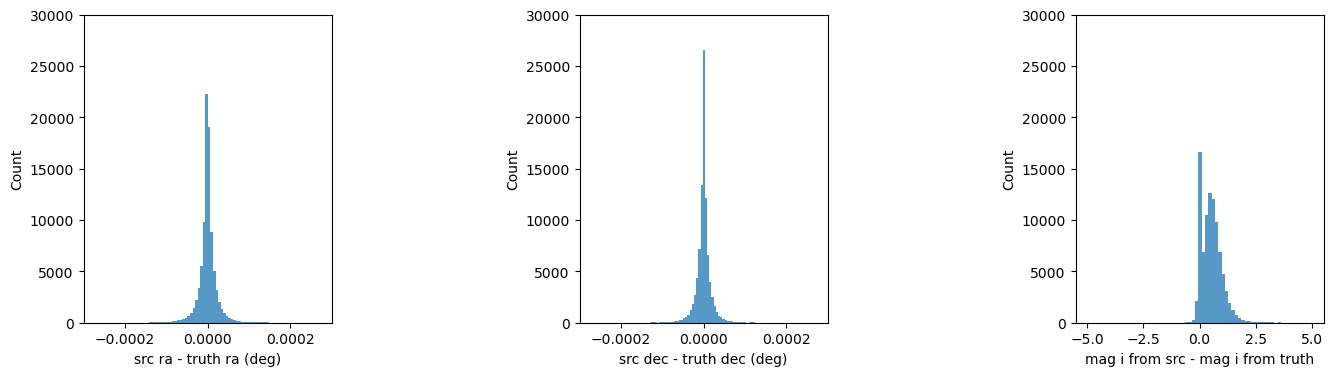

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(wspace=1)
sns.histplot(joint.coord_ra.map(np.rad2deg) - joint.ra, ax=ax[0], bins=100, edgecolor=None)
ax[0].set_xlabel('src ra - truth ra (deg)')
ax[0].set_xlim(-0.0003, 0.0003)
ax[0].set_ylim(0, 30000)

sns.histplot(joint.coord_dec.map(np.rad2deg) - joint.dec, ax=ax[1], bins=100, edgecolor=None)
ax[1].set_xlabel('src dec - truth dec (deg)')
ax[1].set_xlim(-0.0003, 0.0003)
ax[1].set_ylim(0, 30000)

sns.histplot(joint.mag_i_from_PsfFlux - joint.mag_i, ax=ax[2], bins=100, edgecolor=None)
ax[2].set_xlabel('mag i from src - mag i from truth')
ax[2].set_xlim(-5.5, 5.5)
ax[2].set_ylim(0, 30000)

# plt.savefig('./dcr_plots/coord_match.png', dpi=100)

In [13]:
 1 / 3600

0.0002777777777777778

(-10.0, 10.0)

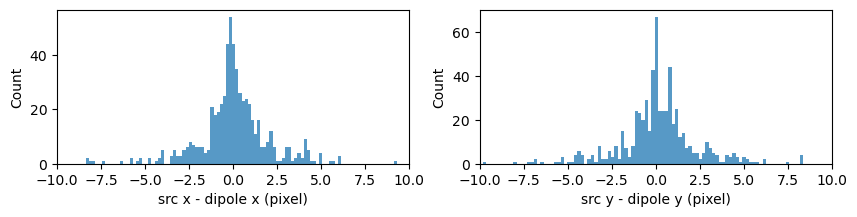

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
fig.subplots_adjust(wspace=0.2)
sns.histplot(joint_dipole.base_NaiveCentroid_x_src - joint_dipole.base_NaiveCentroid_x_dipole, ax=ax[0], bins=100, edgecolor=None)
ax[0].set_xlabel('src x - dipole x (pixel)')
ax[0].set_xlim(-10, 10)
sns.histplot(joint_dipole.base_NaiveCentroid_y_src - joint_dipole.base_NaiveCentroid_y_dipole, bins=100, edgecolor=None)
ax[1].set_xlabel('src y - dipole y (pixel)')
ax[1].set_xlim(-10, 10)

(-0.0003, 0.0003)

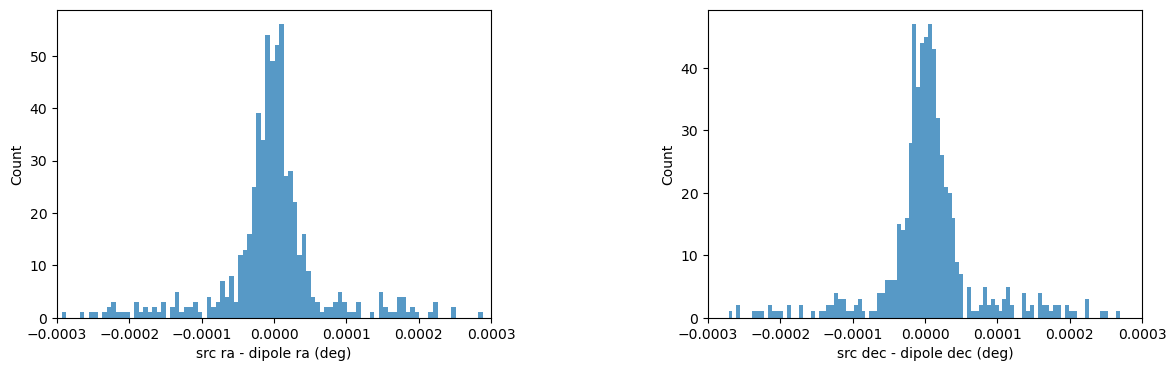

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig.subplots_adjust(wspace=0.5)
sns.histplot(joint_dipole.coord_ra_src.map(np.rad2deg) - joint_dipole.coord_ra_dipole.map(np.rad2deg), ax=ax[0], bins=100, edgecolor=None)
ax[0].set_xlabel('src ra - dipole ra (deg)')
ax[0].set_xlim(-0.0003, 0.0003)
sns.histplot(joint_dipole.coord_dec_src.map(np.rad2deg) - joint_dipole.coord_dec_dipole.map(np.rad2deg), bins=100, edgecolor=None)
ax[1].set_xlabel('src dec - dipole dec (deg)')
ax[1].set_xlim(-0.0003, 0.0003)
# plt.savefig('./dcr_plots/dipole_match.png', dpi=100)

In [16]:
0.2 * 5

1.0

In [17]:
1 / 3600

0.0002777777777777778

the following plot is consistent with Taylor expansion of matching kernl, what is the result of b-spline expansion?

In [21]:
mag = 'mag_i'
# mag = 'mag_i'
# mag = 'mag_i_from_PsfFlux'
joint_cut = joint[joint[mag] > 14].copy().reset_index(drop=True)
joint_cut = joint_cut[[mag, 'distance', 'source_of_dipole']]
joint_cut['n_sources'] = np.repeat(1, len(joint_cut))
joint_cut[mag].min(), joint_cut[mag].max(), joint_cut.distance.min(), joint_cut.distance.max()

(14.007615, 22.999954, 11.52890905044068, 2846.374698411039)

In [22]:
14.007615, 22.999954, 11.52890905044068, 2846.374698411039

(14.007615, 22.999954, 11.52890905044068, 2846.374698411039)

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


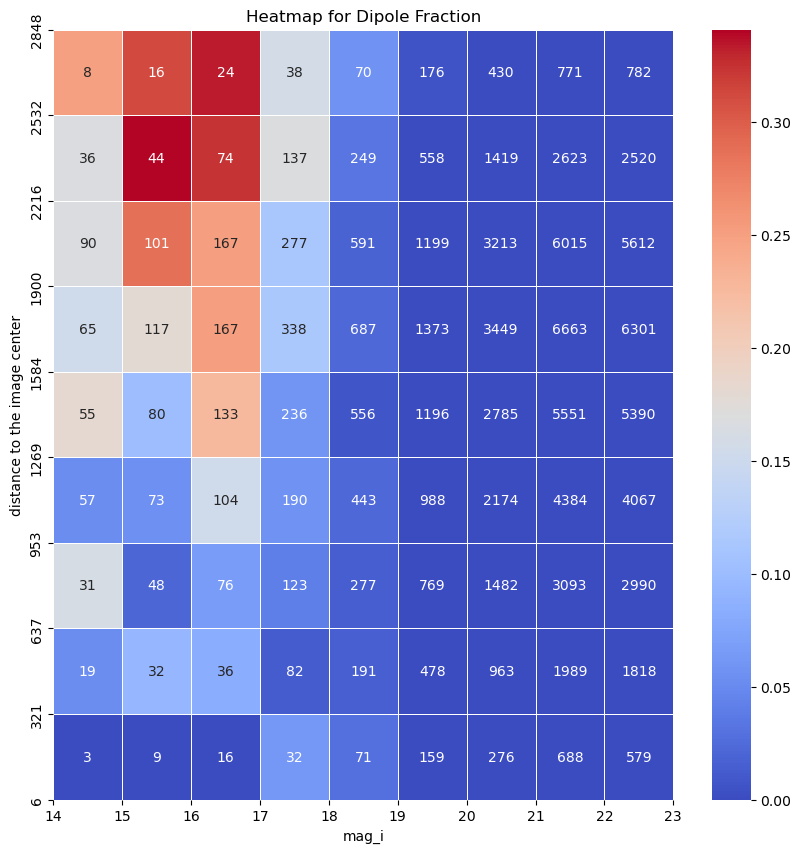

In [23]:
# xbins = list(range(14, 24, 1))
# ybins = list(np.linspace(6, 2848, 10).astype(int))
xbins = list(range(14, 24, 1))
ybins = list(np.linspace(6, 2848, 10).astype(int))
agg_condition = {'source_of_dipole': cal_fraction, 'n_sources': cal_count}
heatmap = get_heatmap(joint_cut, x_name=mag, y_name='distance', 
                      x_bins=xbins, y_bins=ybins, agg_condition=agg_condition,
                      rename_col={'source_of_dipole': 'dipole_fraction'})
title = 'Heatmap for Dipole Fraction'
plot_heatmap(heatmap, xticklabels=xbins, yticklabels=ybins, 
             heat='dipole_fraction', annotation='n_sources',
             xlabel=mag, ylabel='distance to the image center',
             title='Heatmap for Dipole Fraction', figsize=(10, 10))
# plt.savefig('./dcr_plots/heatmap_distance_g.png', dpi=200)

mask saturated flags

In [24]:
len(joint_cut[
    np.logical_and(
        np.logical_and(joint_cut[mag] > 17, joint_cut[mag]<18),
        np.logical_and(joint_cut.distance>1269, joint_cut.distance<1584))])

236

#### color vs. mag i

14.057311 22.999113 -0.5792649999999995 4.188818000000001
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


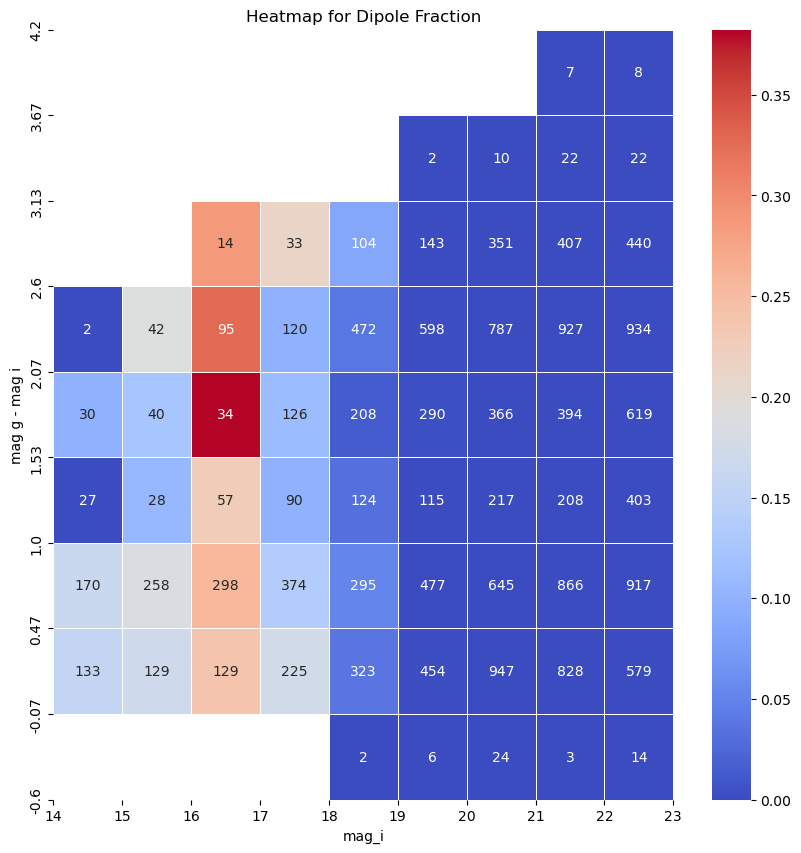

In [25]:
mag = 'mag_i'
color_gi = joint[['mag_g', 'mag_i', 'mag_gi', 'truth_name', 'source_of_dipole', 'truth_type']].copy()
color_gi = color_gi[color_gi[mag] > 14].copy().reset_index(drop=True)
color_gi['n_sources'] = np.repeat(1, len(color_gi))
star = color_gi[color_gi['truth_name']=='star'].copy().reset_index(drop=True)
print(star[mag].min(), star[mag].max(), star['mag_gi'].min(), star['mag_gi'].max())

xbins = list(range(14, 24, 1))
ybins = list(np.linspace(-0.6, 4.2, 10).round(2))
agg_condition = {'source_of_dipole': cal_fraction, 'n_sources': cal_count}
heatmap = get_heatmap(star, x_name=mag, y_name='mag_gi', 
                      x_bins=xbins, y_bins=ybins, agg_condition=agg_condition,
                      rename_col={'source_of_dipole': 'dipole_fraction'})
title = 'Heatmap for Dipole Fraction'
plot_heatmap(heatmap, xticklabels=xbins, yticklabels=ybins, 
             heat='dipole_fraction', annotation='n_sources',
             xlabel=mag, ylabel='mag g - mag i',
             title=title, figsize=(10, 10))
plt.savefig('./dcr_plots/color_vs_mag.png', dpi=200)

In [27]:
len(star[
    np.logical_and(
        np.logical_and(star.mag_i > 16, star.mag_i<17),
        np.logical_and(star.mag_gi>1.53, star.mag_gi<2.07))])

34

#### color vs. mag g, d < 1000

14.165235 22.996805 -0.38089700000000093 4.188818000000001
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


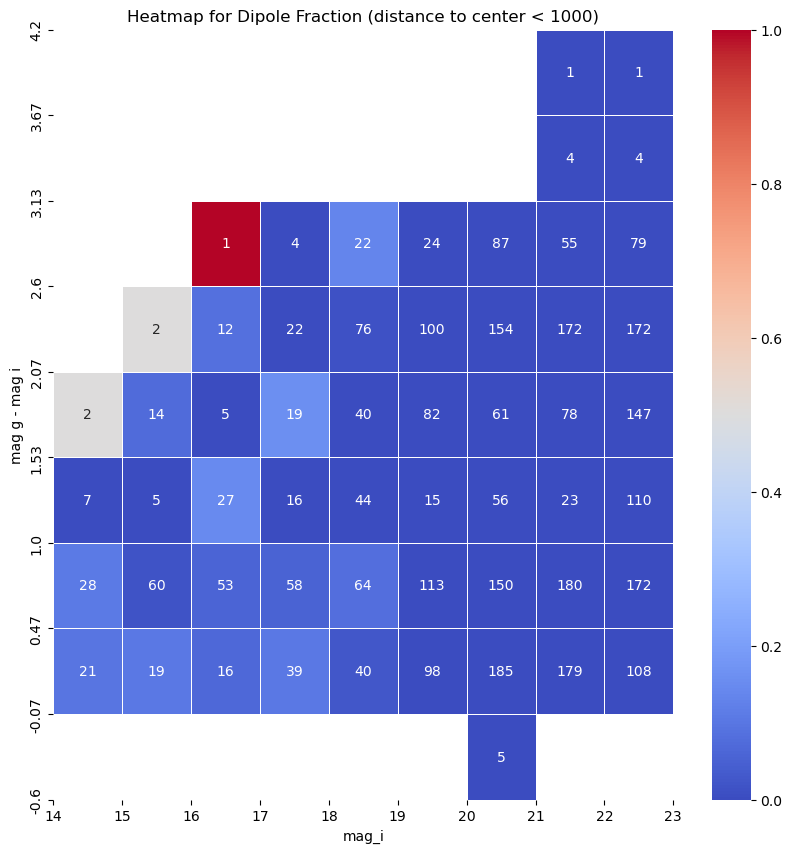

In [28]:
mag = 'mag_i'
color_gi = joint[['mag_g', 'mag_i', 'mag_gi', 'truth_name', 'source_of_dipole', 'truth_type', 'distance']].copy()
color_gi = color_gi[np.logical_and(color_gi[mag] > 14, color_gi.distance < 1000)].copy().reset_index(drop=True)
color_gi['n_sources'] = np.repeat(1, len(color_gi))
star = color_gi[color_gi['truth_name']=='star'].copy().reset_index(drop=True)
print(star[mag].min(), star[mag].max(), star['mag_gi'].min(), star['mag_gi'].max())

xbins = list(range(14, 24, 1))
ybins = list(np.linspace(-0.6, 4.2, 10).round(2))
agg_condition = {'source_of_dipole': cal_fraction, 'n_sources': cal_count}
heatmap = get_heatmap(star, x_name=mag, y_name='mag_gi', 
                      x_bins=xbins, y_bins=ybins, agg_condition=agg_condition,
                      rename_col={'source_of_dipole': 'dipole_fraction'})
title = 'Heatmap for Dipole Fraction (distance to center < 1000)'
plot_heatmap(heatmap, xticklabels=xbins, yticklabels=ybins, 
             heat='dipole_fraction', annotation='n_sources',
             xlabel=mag, ylabel='mag g - mag i',
             title=title, figsize=(10, 10))
plt.savefig('./dcr_plots/color_vs_mag_1000.png', dpi=200)

In [30]:
len(star[
    np.logical_and(
        np.logical_and(star.mag_i > 16, star.mag_i<17),
        np.logical_and(star.mag_gi>2.6, star.mag_gi<3.13))])

1

#### color vs. mag g, 1000< d < 2000

14.057311 22.996805 -0.5021170000000019 4.188818000000001
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


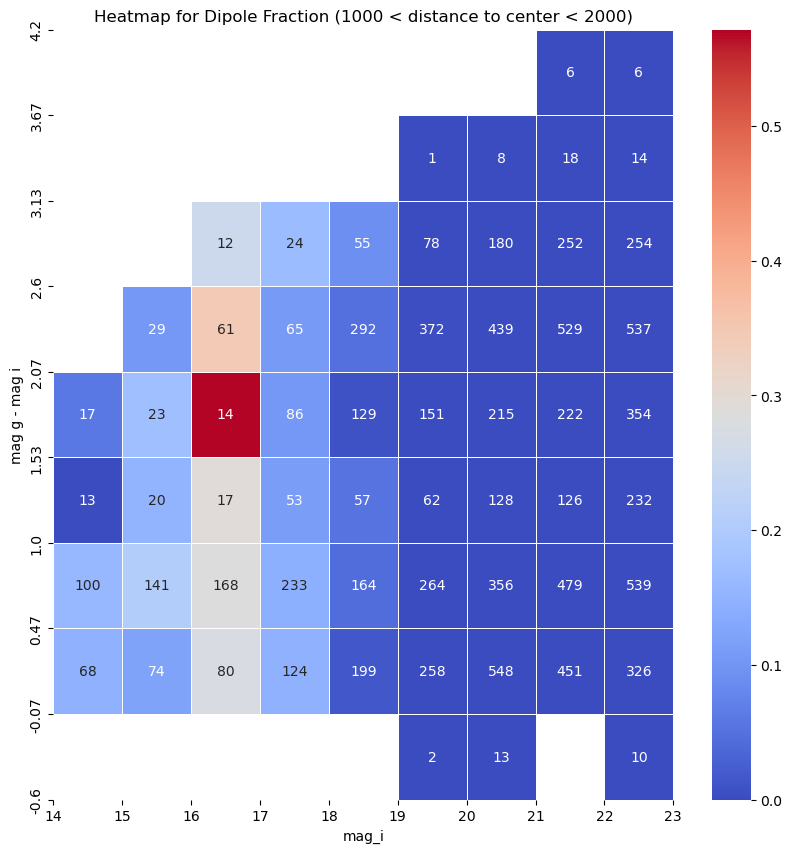

In [31]:
mag = 'mag_i'
color_gi = joint[['mag_g', 'mag_i', 'mag_gi', 'truth_name', 'source_of_dipole', 'truth_type', 'distance']].copy()
color_gi = color_gi[np.logical_and(color_gi[mag]> 14, np.logical_and(color_gi.distance > 1000, color_gi.distance < 2000))].copy().reset_index(drop=True)
color_gi['n_sources'] = np.repeat(1, len(color_gi))
star = color_gi[color_gi['truth_name']=='star'].copy().reset_index(drop=True)
print(star[mag].min(), star[mag].max(), star['mag_gi'].min(), star['mag_gi'].max())

xbins = list(range(14, 24, 1))
ybins = list(np.linspace(-0.6, 4.2, 10).round(2))
agg_condition = {'source_of_dipole': cal_fraction, 'n_sources': cal_count}
heatmap = get_heatmap(star, x_name=mag, y_name='mag_gi', 
                      x_bins=xbins, y_bins=ybins, agg_condition=agg_condition,
                      rename_col={'source_of_dipole': 'dipole_fraction'})
title = 'Heatmap for Dipole Fraction (1000 < distance to center < 2000)'
plot_heatmap(heatmap, xticklabels=xbins, yticklabels=ybins, 
             heat='dipole_fraction', annotation='n_sources',
             xlabel=mag, ylabel='mag g - mag i',
             title=title, figsize=(10, 10))
plt.savefig('./dcr_plots/color_vs_mag_2000.png', dpi=200)

In [34]:
len(star[
    np.logical_and(
        np.logical_and(star.mag_i > 16, star.mag_i<17),
        np.logical_and(star.mag_gi>2.07, star.mag_gi<2.6))])

61

#### dx, dy


In [36]:
bin_center

[0.25, 0.75, 1.25, 1.75, 2.25]

0.2557229999999997 2.408119000000001


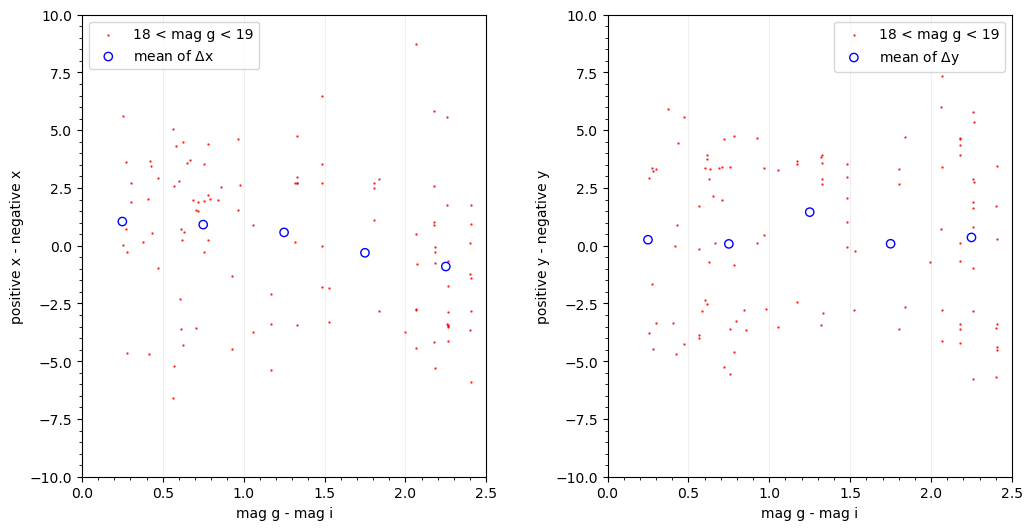

In [35]:
joint_dipole[['mag_g', 'mag_i', 'mag_gi', 'truth_name',
              'ip_diffim_NaiveDipoleCentroid_pos_x', 'ip_diffim_NaiveDipoleCentroid_pos_y',
              'ip_diffim_NaiveDipoleCentroid_neg_x', 'ip_diffim_NaiveDipoleCentroid_neg_y']]
joint_dipole_cut = joint_dipole[np.logical_and(joint_dipole['mag_g']>18, joint_dipole['mag_g']<19)].copy().reset_index(drop=True)
joint_dipole_cut = joint_dipole_cut[joint_dipole_cut['truth_name'] == 'star'].copy().reset_index(drop=True)

print(joint_dipole_cut.mag_gi.min(), joint_dipole_cut.mag_gi.max())

dx = joint_dipole_cut.ip_diffim_NaiveDipoleCentroid_pos_x - joint_dipole_cut.ip_diffim_NaiveDipoleCentroid_neg_x
dy = joint_dipole_cut.ip_diffim_NaiveDipoleCentroid_pos_y - joint_dipole_cut.ip_diffim_NaiveDipoleCentroid_neg_y
joint_dipole_cut['dx'] = dx
joint_dipole_cut['dy'] = dy

bins = [0 , 0.5, 1 , 1.5, 2 , 2.5]
bin_center = [bins[i]+0.25 for i in range(len(bins)-1)]
bin_id = pd.cut(joint_dipole_cut['mag_gi'], bins=bins, labels=False, include_lowest=True)

joint_dipole_cut['bin_id'] = bin_id
joint_dipole_cut['mean_dx'] = joint_dipole_cut['dx'].copy()
joint_dipole_cut['mean_dy'] = joint_dipole_cut['dy'].copy()

mean_positions = joint_dipole_cut.groupby(['bin_id']).agg({'mean_dx': np.mean, 'mean_dy': np.mean}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].scatter(joint_dipole_cut.mag_gi, dx, s=0.5, alpha=0.8, color='r', label='18 < mag g < 19')
ax[0].scatter(bin_center, mean_positions.mean_dx, marker='o', facecolor='None', color='blue', label='mean of $\Delta$x')
ax[0].set_xlim(0, 2.5)
ax[0].set_ylim(-10,10)
ax[0].minorticks_on()
ax[0].set_xlabel('mag g - mag i')
ax[0].set_ylabel('positive x - negative x')
ax[0].grid(True, axis='x', alpha=0.2)
ax[0].legend()

ax[1].scatter(joint_dipole_cut.mag_gi, dy, s=0.5, alpha=0.8, color='r', label='18 < mag g < 19')
ax[1].scatter(bin_center, mean_positions.mean_dy, marker='o', facecolor='None', color='blue', label='mean of $\Delta$y')

ax[1].set_xlim(0, 2.5)
ax[1].set_ylim(-10,10)
ax[1].minorticks_on()
ax[1].set_xlabel('mag g - mag i')
ax[1].set_ylabel('positive y - negative y')
ax[1].grid(True, axis='x', alpha=0.2)
ax[1].legend()
plt.savefig('./dcr_plots/dx_dy.png', dpi=100)

look up the value and angle of the dipole, 

differnce between pos / neg vs. angle

In [70]:
dipole.filter(like='Dipole').columns

Index(['ip_diffim_NaiveDipoleCentroid_flag',
       'ip_diffim_NaiveDipoleCentroid_pos_flag',
       'ip_diffim_NaiveDipoleCentroid_neg_flag',
       'ip_diffim_NaiveDipoleCentroid_x', 'ip_diffim_NaiveDipoleCentroid_y',
       'ip_diffim_NaiveDipoleCentroid_xErr',
       'ip_diffim_NaiveDipoleCentroid_yErr',
       'ip_diffim_NaiveDipoleCentroid_pos_x',
       'ip_diffim_NaiveDipoleCentroid_pos_y',
       'ip_diffim_NaiveDipoleCentroid_pos_xErr',
       'ip_diffim_NaiveDipoleCentroid_pos_yErr',
       'ip_diffim_NaiveDipoleCentroid_neg_x',
       'ip_diffim_NaiveDipoleCentroid_neg_y',
       'ip_diffim_NaiveDipoleCentroid_neg_xErr',
       'ip_diffim_NaiveDipoleCentroid_neg_yErr',
       'ip_diffim_NaiveDipoleFlux_flag', 'ip_diffim_NaiveDipoleFlux_pos_flag',
       'ip_diffim_NaiveDipoleFlux_neg_flag',
       'ip_diffim_NaiveDipoleFlux_pos_instFlux',
       'ip_diffim_NaiveDipoleFlux_pos_instFluxErr',
       'ip_diffim_NaiveDipoleFlux_neg_instFlux',
       'ip_diffim_NaiveDipoleFlux_ne

In [ ]:
p_diffim_DipoleFit_orientation'

In [ ]:
p_diffim_DipoleFit_flag_classification',
       'ip_diffim_DipoleFit_flag_classificationAttempted',
       'ip_diffim_DipoleFit_flag',

In [74]:
artifacts.ip_diffim_DipoleFit_flag_classificationAttempted.sum()

783

In [75]:
artifacts.ip_diffim_DipoleFit_flag_classification.sum()

777

In [76]:
len(artifacts)

2446

In [ ]:
artifacts.ip_diffim_DipoleFit_flag_classification

In [ ]:
    'ip_diffim_ClassificationDipole_value',
       'ip_diffim_ClassificationDipole_flag',

In [80]:
# artifacts.ip_diffim_ClassificationDipole_value.sum()

289.0

In [82]:
artifacts.ip_diffim_ClassificationDipole_flag.sum()

0

In [37]:
from lsst.afw.table import BaseCatalog

In [38]:
t = BaseCatalog.readFits('/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
                         '/patch_0to6/diff/al_default_v23/00_20_21_1013665_79_i/diff_20/schema/deepDiff_diaSrc.fits')
t_astropy = t.asAstropy()
schema = t.schema

In [42]:
flag = 'ip_diffim_DipoleFit_flag_classification'
schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()

'Flag indicating diaSource is classified as a dipole'

In [43]:
flag = 'ip_diffim_DipoleFit_flag_classificationAttempted'
schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()

'Flag indicating diaSource was attempted to be classified as a dipole'

In [40]:
flag = 'ip_diffim_ClassificationDipole_value'
schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()

'Set to 1 for dipoles, else 0.'

In [41]:
flag = 'ip_diffim_ClassificationDipole_flag'
schema.extract(f"{flag}")[f'{flag}'].getField().getDoc()

'Set to 1 for any fatal failure.'